In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# pip install pandas-profiling
import pandas_profiling as pdp
import seaborn as sns
%matplotlib inline

traps = pd.read_csv('assets/train.csv')
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Preliminary EDA

In [ ]:
# pdp.ProfileReport(traps)
# pdp.ProfileReport(spray)
# pdp.ProfileReport(weather)

# sns.pairplot(traps)
# sns.pairplot(spray)
# sns.pairplot(weather)

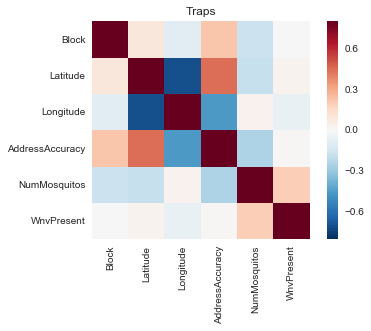

In [4]:
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

# Data Transformation

## Modify columns

In [5]:
import datetime
# Convert Date columns to actual date data type
traps.Date = pd.to_datetime(traps.Date)
spray.Date = pd.to_datetime(spray.Date)
weather.Date = pd.to_datetime(weather.Date)

# Create dummies for Species and Trap
dummies = pd.get_dummies(traps, columns=['Species'])

# Create a new df with the dummies
traps_2_cols = traps.columns.drop('Species')
traps_2 = pd.concat([traps[traps_2_cols],dummies])

# Weather data:
# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data
weather.PrecipTotal = weather.PrecipTotal.str.replace('T','0.005')
weather.PrecipTotal = weather.PrecipTotal.str.replace('M','0.0')
weather.PrecipTotal = weather.PrecipTotal.astype(float)

## Grouping records from same trap, same day inspection

In [6]:
# Because records are capped at 50 mosquitos,
# we are grouping the data to obtain a unique
# observation record per trap per date, with
# a total sum of NumMosquitos

traps = traps[['Trap',
               'Latitude',
               'Longitude',
               'Date',
               'Species',
               'WnvPresent',
               'NumMosquitos']].groupby(['Trap',
                                         'Latitude',
                                         'Longitude',
                                         'Date', 
                                         'Species',
                                         'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

## Applying the weather data to the dataframe

In [7]:
## This function takes three arguments:
## The column name as a string from weather dataframe that we want to extract
## a numpy function that we want to do to the data
## an integer number of previous days to extraxct

def weather_add(weather_col, func, days_range=7):
    new_list = []
    for i in traps['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [8]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days.

traps['Tmax'] = weather_add(weather_col='Tmax', func=np.mean)
traps['Tmin'] = weather_add(weather_col='Tmin', func=np.mean)
traps['rain'] = weather_add(weather_col='PrecipTotal', func= np.sum)

## Applying the spray data to the dataframe

In [11]:
from geopy.distance import vincenty
## create a feature displaying the closest spray to the trap where applicable
## takes about 10 minutes to run so beware
traps['Spray'] = np.NaN

## get trap observations for dates with spray data
traps_sprayed = traps[traps.Date>=min(spray.Date)]
## record the indices of these records for when we set the spray values to the main df
traps_indices = traps_sprayed.index.values

start= datetime.datetime.now()
print start

remaining = len(traps_indices)
    
for i in traps_indices:
    trap_lat = traps_sprayed.Latitude.loc[i]
    trap_long = traps_sprayed.Longitude.loc[i]
    # record the date of a week prior to the inspection
    trap_week_ago = traps_sprayed.Date.loc[i] - pd.Timedelta(days=7)
    dist = []
    # for each dated trap inspection, select only the spray records within a week prior to the inspection
    spray_temp = spray[['Latitude','Longitude']][spray.Date >= trap_week_ago][spray.Date<=traps_sprayed.Date.loc[i]]
    remaining-=1
    print str(remaining),' remaining'
    
    # run through each coordinate in the spray data and record the distance
    for j in range(0,len(spray_temp)):
        spray_lat = spray.Latitude.iloc[j] 
        spray_long = spray.Longitude.iloc[j]
        a = (trap_lat, trap_long)
        b = (spray_lat, spray_long)
        # calculate the distance between the points
        dist.append(vincenty(a, b).miles)
    try:
        # set the spray value to the shortest distance
        traps.Spray.loc[i] = min(dist)
    except:
        pass

elapsed = datetime.datetime.now() - start
print elapsed        

2017-04-20 18:53:14.556442
2546  remaining
2545  remaining
2544 

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 remaining
2543  remaining
2542  remaining
2541  remaining
2540  remaining
2539  remaining
2538  remaining
2537  remaining
2536  remaining
2535  remaining
2534  remaining
2533  remaining
2532  remaining
2531  remaining
2530  remaining
2529  remaining
2528  remaining
2527  remaining
2526  remaining
2525  remaining
2524  remaining
2523  remaining
2522  remaining
2521  remaining
2520  remaining
2519  remaining
2518  remaining
2517  remaining
2516  remaining
2515  remaining
2514  remaining
2513  remaining
2512  remaining
2511  remaining
2510  remaining
2509  remaining
2508  remaining
2507  remaining
2506  remaining
2505  remaining
2504  remaining
2503  remaining
2502  remaining
2501  remaining
2500  remaining
2499  remaining
2498  remaining
2497  remaining
2496  remaining
2495  remaining
2494  remaining
2493  remaining
2492  remaining
2491  remaining
2490  remaining
2489  remaining
2488  remaining
2487  remaining
2486  remaining
2485  remaining
2484  remaining
2483  remaining
2482  remaini

In [12]:
traps.to_csv('/Users/jennydoyle/Desktop/dsi/West-Nile-Virus-Prediction/assets/traps_spray_distance.csv',sep=',', encoding='utf-8')

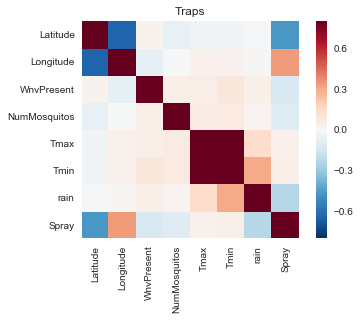

In [13]:
## Check out how the correlation map changes with our new features
find_correlation(traps, 'Traps')

## Scale the Data ??

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# how do we reconcile null distances for nearest spray?
# setting them to zero implies the spray is super close
# this cell is still in progress... 
max_dist = max(traps.spray)+100
traps.spray = traps.spray.fillna(max_dist)

features = traps.columns.drop(['Species','Date','Trap'])

traps[features].head()

traps_rescaled =  pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)
traps_rescaled.concat(traps[['Species','Date','Trap']])

traps['spray_scaled'] = np.NaN           
min_dist = min(traps.spray)
traps.spray_scaled = traps.spray.map(lambda x: x/float(max_dist))   

traps[['spray_scaled','spray']].sort('spray')